# Molecule property regression with message-passing network

### Preamble

In [14]:
!pip install dgl
!pip install uproot

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch
import dgl
from dgl.data import QM9EdgeDataset
from tqdm import tqdm
import json
import sys
# sys.path.append('/content/drive/My Drive/ColabNotebooks/weizmannCode/')


/usr/local/anaconda/3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# from google.colab import drive
# drive.mount('/content/drive')

### QM9EdgeDataset
DGL provides a preloaded interface to this dataset of 130k molecules
- https://docs.dgl.ai/en/0.8.x/generated/dgl.data.QM9EdgeDataset.html
- http://quantum-machine.org/datasets/

We want to train a graph neural network to regress the magnitude of the \
electric dipole moment $|\vec{\mu}|$ of the molecule, where:

$\vec{\mu} = \sum_{i} q_i \vec{x_i}$

In [17]:
# from nbconvert.exporters.templateexporter import ROOT
# myFile = ROOT.TFile.Open("file.root")
# config_path = '/content/drive/My Drive/ColabNotebooks/weizmannCode/cocoa_default.json'
config_path = "cocoa_default.json"
with open(config_path, 'r') as f:
    config = json.load(f)

config['batchsize']     = 6
config['reduce_ds']     = config['batchsize']


In [18]:
# data = QM9EdgeDataset(label_keys=['mu'])
from  dataset import PflowDataset
ds = PflowDataset('val_skim.root',config,reduce_ds=config['reduce_ds']) #,entry_start=config['entry_start'])


100%|██████████| 48/48 [00:00<00:00, 1105.58it/s]


dataset loaded
number of events: 6



In [19]:
len(ds)

6

In [31]:
g, labels = ds.__getitem__(4)

In [45]:
print(g)

Graph(num_nodes={'cell': 236, 'global_node': 1, 'node': 237, 'particle': 1, 'pflow_particle': 1, 'pre_node': 237, 'topo': 7, 'track': 1},
      num_edges={('node', 'node_to_node', 'node'): 2056},
      metagraph=[('node', 'node', 'node_to_node')])


In [33]:
from visualizer import draw_plotly
# draw_plotly(g)

ModuleNotFoundError: No module named 'plotly'

In [34]:
from model import MoleculeMPNN

In [35]:
net = MoleculeMPNN()

In [36]:
### number of parameters ###
sum(p.numel() for p in net.parameters())

371713

In [37]:
### Modified from https://docs.dgl.ai/en/0.2.x/tutorials/basics/4_batch.html ###
def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.row_stack(labels)
    return batched_graph, labels

In [38]:
train_dataset = torch.utils.data.Subset(ds,range(3))
valid_dataset = torch.utils.data.Subset(ds,range(3,4))
test_dataset = torch.utils.data.Subset(ds,range(4,len(ds)-1))

train_dataloader = DataLoader(train_dataset, batch_size=200, shuffle=True, collate_fn=collate, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=200, collate_fn=collate, num_workers=4)
test_dataloader  = DataLoader(test_dataset,  batch_size=1, collate_fn=collate, num_workers=0)

In [47]:
net(g)

TypeError: expected Tensor as element 0 in argument 0, but got dict

In [ ]:
from training import train_valid_loop

train_loss, valid_loss = train_valid_loop(net, train_dataloader, valid_dataloader, 10)

  0%|          | 0/10 [00:18<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 17048, 21992, 19208, 6868) exited unexpectedly

In [ ]:
### Reload stored values ###
train_loss = np.load('train_loss.npy')
valid_loss = np.load('valid_loss.npy')

FileNotFoundError: [Errno 2] No such file or directory: 'train_loss.npy'

In [ ]:
### Load saved model ###
net.load_state_dict(torch.load('saved_model.pt',map_location=torch.device('cpu')))

FileNotFoundError: [Errno 2] No such file or directory: 'saved_model.pt'

NameError: name 'train_loss' is not defined

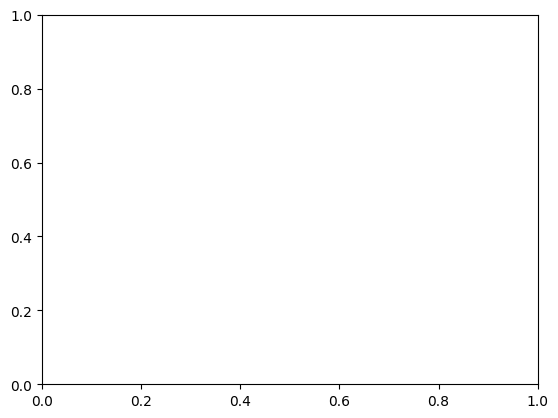

In [ ]:
fig, axes = plt.subplots()
axes.plot(range(len(train_loss)),train_loss,label='train loss')
axes.plot(range(len(valid_loss)),valid_loss,label='valid loss')
#axes.set_yscale('log')
#axes.set_ylim([1e-2,1e0])
axes.legend()
plt.show()

In [ ]:
preds, trues = [], []

for i in tqdm(range(len(test_dataset))):
    g, labels = test_dataset.__getitem__(i)
    preds.append(net(g).detach().numpy().item())
    trues.append(labels.item())

preds = np.array(preds)
trues = np.array(trues)

0it [00:00, ?it/s]


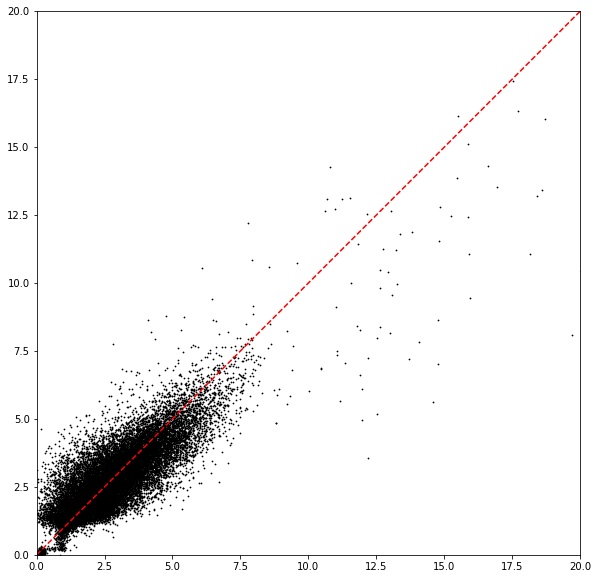

In [ ]:
fig, axes = plt.subplots(figsize=(10,10))
axes.scatter(trues,preds,s=0.6,c='black')
axes.plot([0,20],[0,20],c='red',ls='--')
axes.set_xlim(0,20)
axes.set_ylim(0,20)
axes.set_aspect('equal')

Text(0.5, 0, 'pred - true / true')

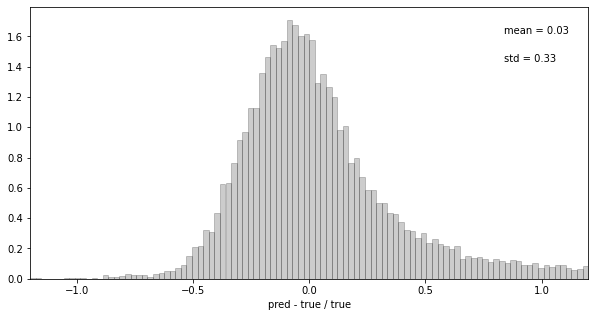

In [ ]:
resids = (preds-trues)/(trues+1e-6)
resids = resids[abs(resids) < 1.2]

fig, axes = plt.subplots(figsize=(10,5))
h = axes.hist(resids,bins=100,range=(-1.2,1.2),facecolor='black',alpha=0.2,density=True,lw=1,edgecolor='black')
axes.set_xlim(-1.2,1.2)
axes.text(0.85,0.9,'mean = {:.2f}'.format(np.mean(resids)),transform=axes.transAxes)
axes.text(0.85,0.8,'std = {:.2f}'.format(np.std(resids)),transform=axes.transAxes)
axes.set_xlabel('pred - true / true')